In [3]:
! pip install textract-trp

In [7]:
#Analyzes text in a document stored in an S3 bucket. Display polygon box around text and angled text 
import boto3
import io
from PIL import Image, ImageDraw
import json

def ShowBoundingBox(draw,box,width,height,boxColor):      
    left = width * box['Left']
    top = height * box['Top'] 
    draw.rectangle([left,top, left + (width * box['Width']), top +(height * box['Height'])],outline=boxColor)   

def ShowSelectedElement(draw,box,width,height,boxColor):
             
    left = width * box['Left']
    top = height * box['Top'] 
    draw.rectangle([left,top, left + (width * box['Width']), top +(height * box['Height'])],fill=boxColor)  

# Displays information about a block returned by text detection and text analysis
def DisplayBlockInformation(block):
    print('Id: {}'.format(block['Id']))
    if 'Text' in block:
        print('    Detected: ' + block['Text'])
    print('    Type: ' + block['BlockType'])
   
    if 'Confidence' in block:
        print('    Confidence: ' + "{:.2f}".format(block['Confidence']) + "%")

    if block['BlockType'] == 'CELL':
        print("    Cell information")
        print("        Column:" + str(block['ColumnIndex']))
        print("        Row:" + str(block['RowIndex']))
        print("        Column Span:" + str(block['ColumnSpan']))
        print("        RowSpan:" + str(block['ColumnSpan']))    
    
    if 'Relationships' in block:
        print('    Relationships: {}'.format(block['Relationships']))
    print('    Geometry: ')
    print('        Bounding Box: {}'.format(block['Geometry']['BoundingBox']))
    print('        Polygon: {}'.format(block['Geometry']['Polygon']))
    
    if block['BlockType'] == "KEY_VALUE_SET":
        print ('    Entity Type: ' + block['EntityTypes'][0])
    
    if block['BlockType'] == 'SELECTION_ELEMENT':
        print('    Selection element detected: ', end='')

        if block['SelectionStatus'] =='SELECTED':
            print('Selected')
        else:
            print('Not selected')    
    
    if 'Page' in block:
        print('Page: ' + block['Page'])
    print()

def process_text_analysis(bucket, document, region):

    #Get the document from S3
    s3_connection = boto3.resource('s3')
                          
    s3_object = s3_connection.Object(bucket,document)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)
    
    # Analyze the document
    client = boto3.client('textract', region_name=region)
    
    image_binary = stream.getvalue()
    response = client.analyze_document(Document={'Bytes': image_binary},
        FeatureTypes=["TABLES", "FORMS"])
    with open("response_sample2.json", "w") as fwriter:
        json.dump(response, fwriter)
    ### Uncomment to process using S3 object ###
    #response = client.analyze_document(
    #    Document={'S3Object': {'Bucket': bucket, 'Name': document}},
    #    FeatureTypes=["TABLES", "FORMS"])

    ### Uncomment to analyze a local file ###
    # with open("pathToFile", 'rb') as img_file:
        ### To display image using PIL ###
    #    image = Image.open()
        ### Read bytes ###
    #    img_bytes = img_file.read()
    #    response = client.analyze_document(Document={'Bytes': img_bytes}, FeatureTypes=["TABLES", "FORMS"])
    
    #Get the text blocks
    blocks=response['Blocks']
    width, height =image.size    
    print ('Detected Document Text')
   
    # Create image showing bounding box/polygon the detected lines/text
    for block in blocks:
        DisplayBlockInformation(block)    
        draw=ImageDraw.Draw(image)

        # Draw bounding boxes for different detected response objects
        if block['BlockType'] == "KEY_VALUE_SET":
            if block['EntityTypes'][0] == "KEY":
                ShowBoundingBox(draw, block['Geometry']['BoundingBox'],width,height,'red')
            else:
                ShowBoundingBox(draw, block['Geometry']['BoundingBox'],width,height,'green')             
        if block['BlockType'] == 'TABLE':
            ShowBoundingBox(draw, block['Geometry']['BoundingBox'],width,height, 'blue')
        if block['BlockType'] == 'CELL':
            ShowBoundingBox(draw, block['Geometry']['BoundingBox'],width,height, 'yellow')
        if block['BlockType'] == 'SELECTION_ELEMENT':
            if block['SelectionStatus'] =='SELECTED':
                ShowSelectedElement(draw, block['Geometry']['BoundingBox'],width,height, 'blue')    
            
    # Display the image
    image.show()
    return len(blocks)

def query_document(bucket, document, region, question):
    # Analyze the document
    client = boto3.client('textract', region_name=region)
    response = client.analyze_document(Document={'S3Object': {'Bucket': bucket, 'Name': document}},
                                       FeatureTypes=["TABLES", "FORMS", "QUERIES"],
                                       QueriesConfig={'Queries':[
                                           {'Text':'{}'.format(question)}
                                       ]})
    
    for block in response['Blocks']:
        if block["BlockType"] == "QUERY":
            print("Query info:")
            print(block["Query"])
        #print(block)
        if block["BlockType"] == "QUERY_RESULT":
            print("Query answer:")
            print(block["Text"])

Detected Document Text
Id: 3441aa1b-93e3-4956-8a15-9cf28ed87d79
    Type: PAGE
    Relationships: [{'Type': 'CHILD', 'Ids': ['54aa7572-5e3e-40d8-b835-fd25a017c393', '95213d7a-5fdc-4b5b-b927-7e74abf9fcc3', '86ff285a-eb93-47de-814e-87bad14ebc87', '838bbbc4-6339-4548-8f68-3eb9caee9e2f', '374de030-66eb-4817-8bcc-56da8a6d9f63', '7bc0dfb3-2b28-496e-ab33-8873de01ba4b', '3105e613-9fd1-4738-bcd6-e63b91e046a1', 'b7dbb42a-cc34-4067-9e1a-a5d59cc472f0', '7eaba223-92df-4a84-86bf-f49a380b2206', '2c716284-d562-47f7-915c-2bfa81d2c01d', 'cb88b04b-7ff4-4b83-adf7-72d9b5894cf1', 'acee73fc-0580-4e8d-82f2-a14a2d208145', '93bfbcd4-f53f-4652-9560-cf77c4fe4a0f', '0ca3719b-5b3d-44c1-8eb2-b02cf5ec9188', 'b1a0e60d-2220-4ab3-9bae-ff36e5c7d723', 'eb7f24e9-b949-4762-bd83-0f50cb290c16', '11263fde-a346-4704-8654-8b9e36f3640c', 'd8982df7-8588-46d7-8b27-0a30d99bfdda', '5f899eb2-1112-467e-8667-e1cbb36d13a2', '5dc57350-8fff-475c-a421-301f86f460ac', '067c3ce2-11ff-4350-811e-91c659f9f0de', '710cdb5c-5d6e-4988-acbf-d5e16dc592

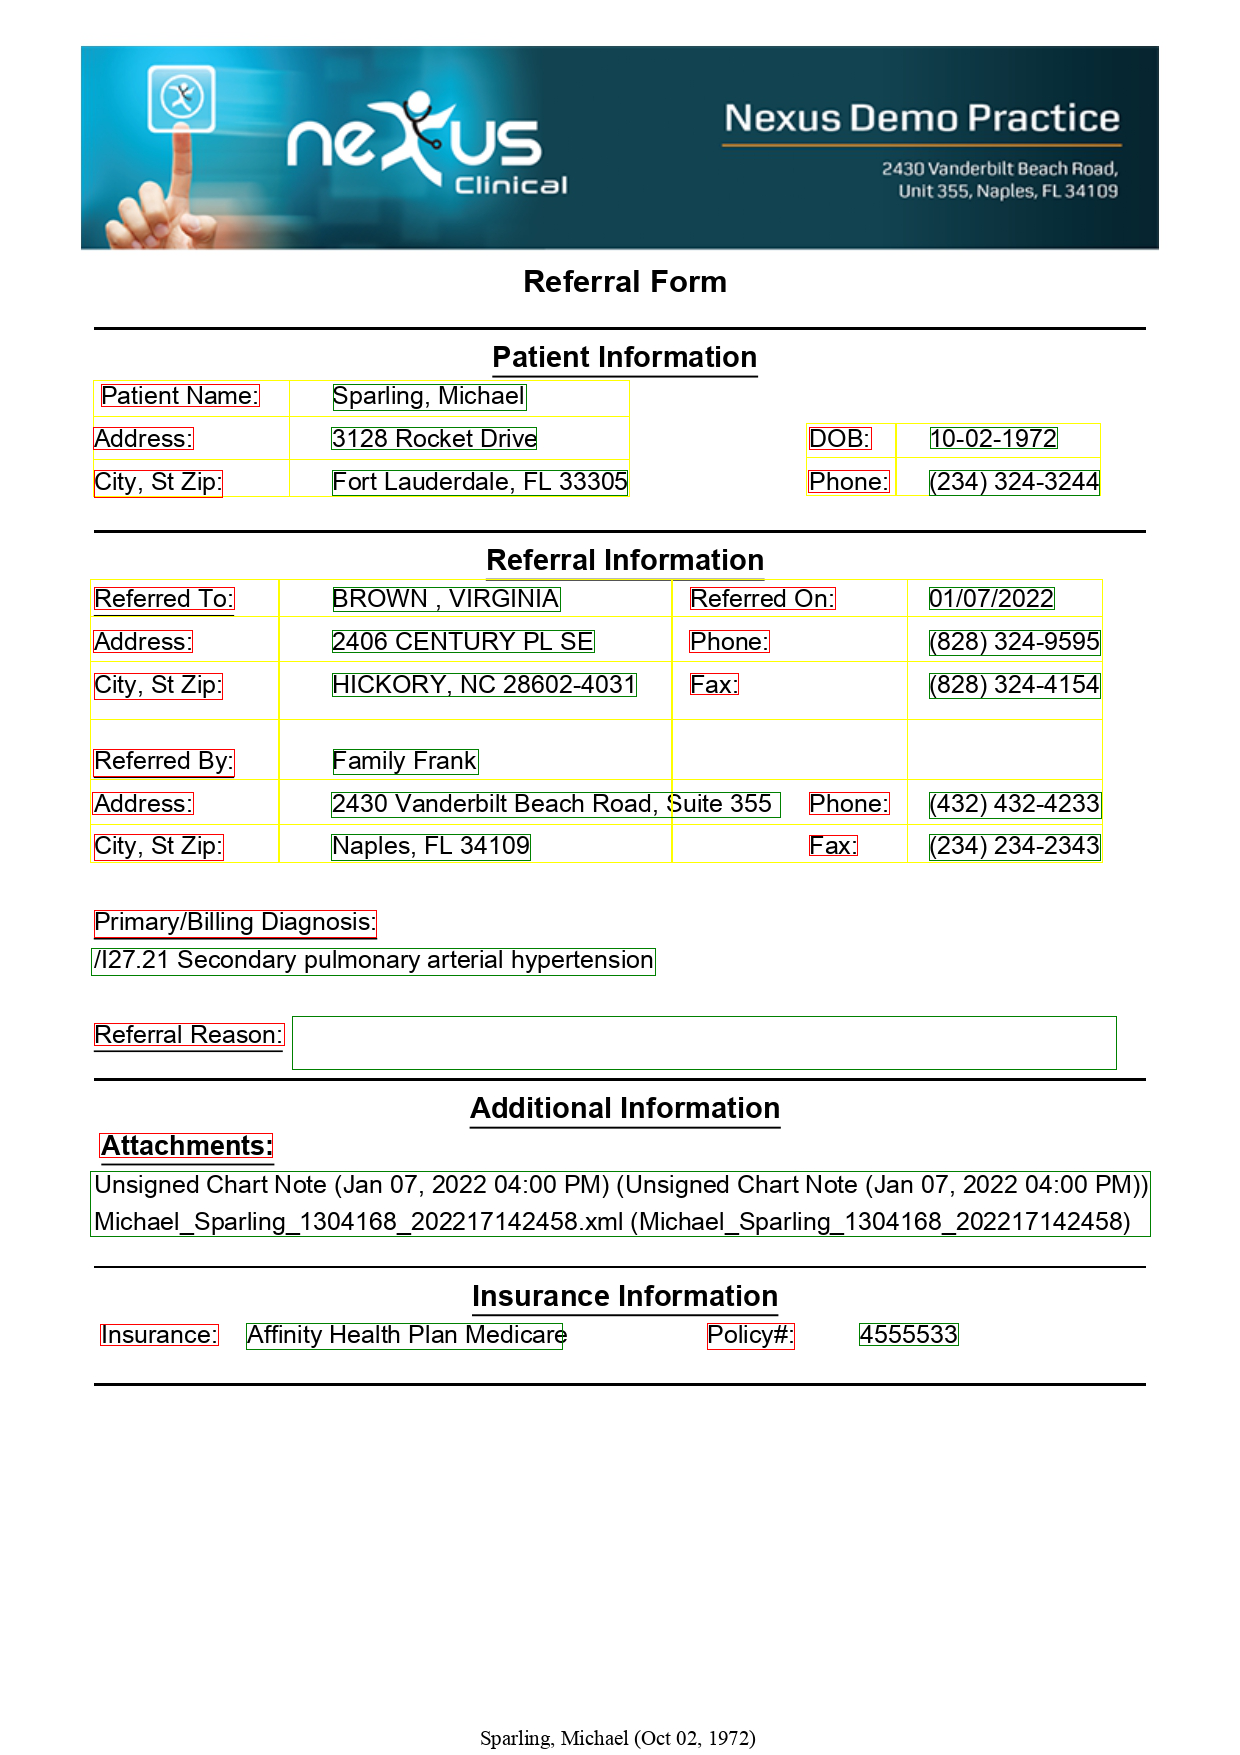

Blocks detected: 266


In [2]:

bucket = "textract-console-ap-south-1-13d8bdf3-2ddb-471a-a8ca-3ea2325bd65"
document = "sample2.jpg"
region = "ap-south-1"
block_count=process_text_analysis(bucket, document, region)
    # uncomment to run query
    # question = ""
    # query_document(bucket, document, region, question)
print("Blocks detected: " + str(block_count))

In [3]:
import trp, json

In [4]:
with open("response.json") as freader:
    content = json.load(freader)

In [5]:
doc = trp.Document(content)

In [7]:
doc

In [8]:
image=Image.open("page1.jpg")
draw=ImageDraw.Draw(image)
width, height =image.size  
bbox = {"Width": 0.905, "Height": 0.1,"Left": 0.04, "Top": 0.21}
ShowBoundingBox(draw, bbox, width, height,'red')

In [24]:
print(doc.pages[0].tables[1])

Table
Row
[Billing Information ][Bill To: Patient ]
Row
[Primary Ins Code: N/A ][Secondary Ins Code: N/A ]
Row
[Primary Ins Name: AARP Medicare Complete by ][Secondary Ins Name: HMO Blue of Texas / Blue Cross & ]
Row
[SecureHorizons ][Blue Shield of TX ]
Row
[Address: 123 main st ][Address: 123 Eat St ]
Row
[City, St Zip: New York NY 10012 ][City, St Zip: Naples FL 34109 ]
Row
[Subscriber#: ][Subscriber#: ]
Row
[Policy#: 1223 ][Policy#: 5466 ]
Row
[Group#: ][Group#: ]
Row
[Emp/Group Name: ][Emp/Group Name: ]
Row
[Insured: Doe, John ][Insured: Doe, John ]
Row
[Address: 21st Old church rd A21 ][Address: 21st Old church rd A21 ]
Row
[City, St Zip: sandigo CA 45454-5456 ][City, St Zip: sandigo CA 45454-5456 ]
Row
[Relationship: Self ][Relationship: Self ]



In [20]:
doc.pages[0].tables[-1].rows[0].cells[0].text

'ICD Code '

In [22]:
doc.pages[0].tables[-1].rows[1].cells[0].text

'K80.81 '

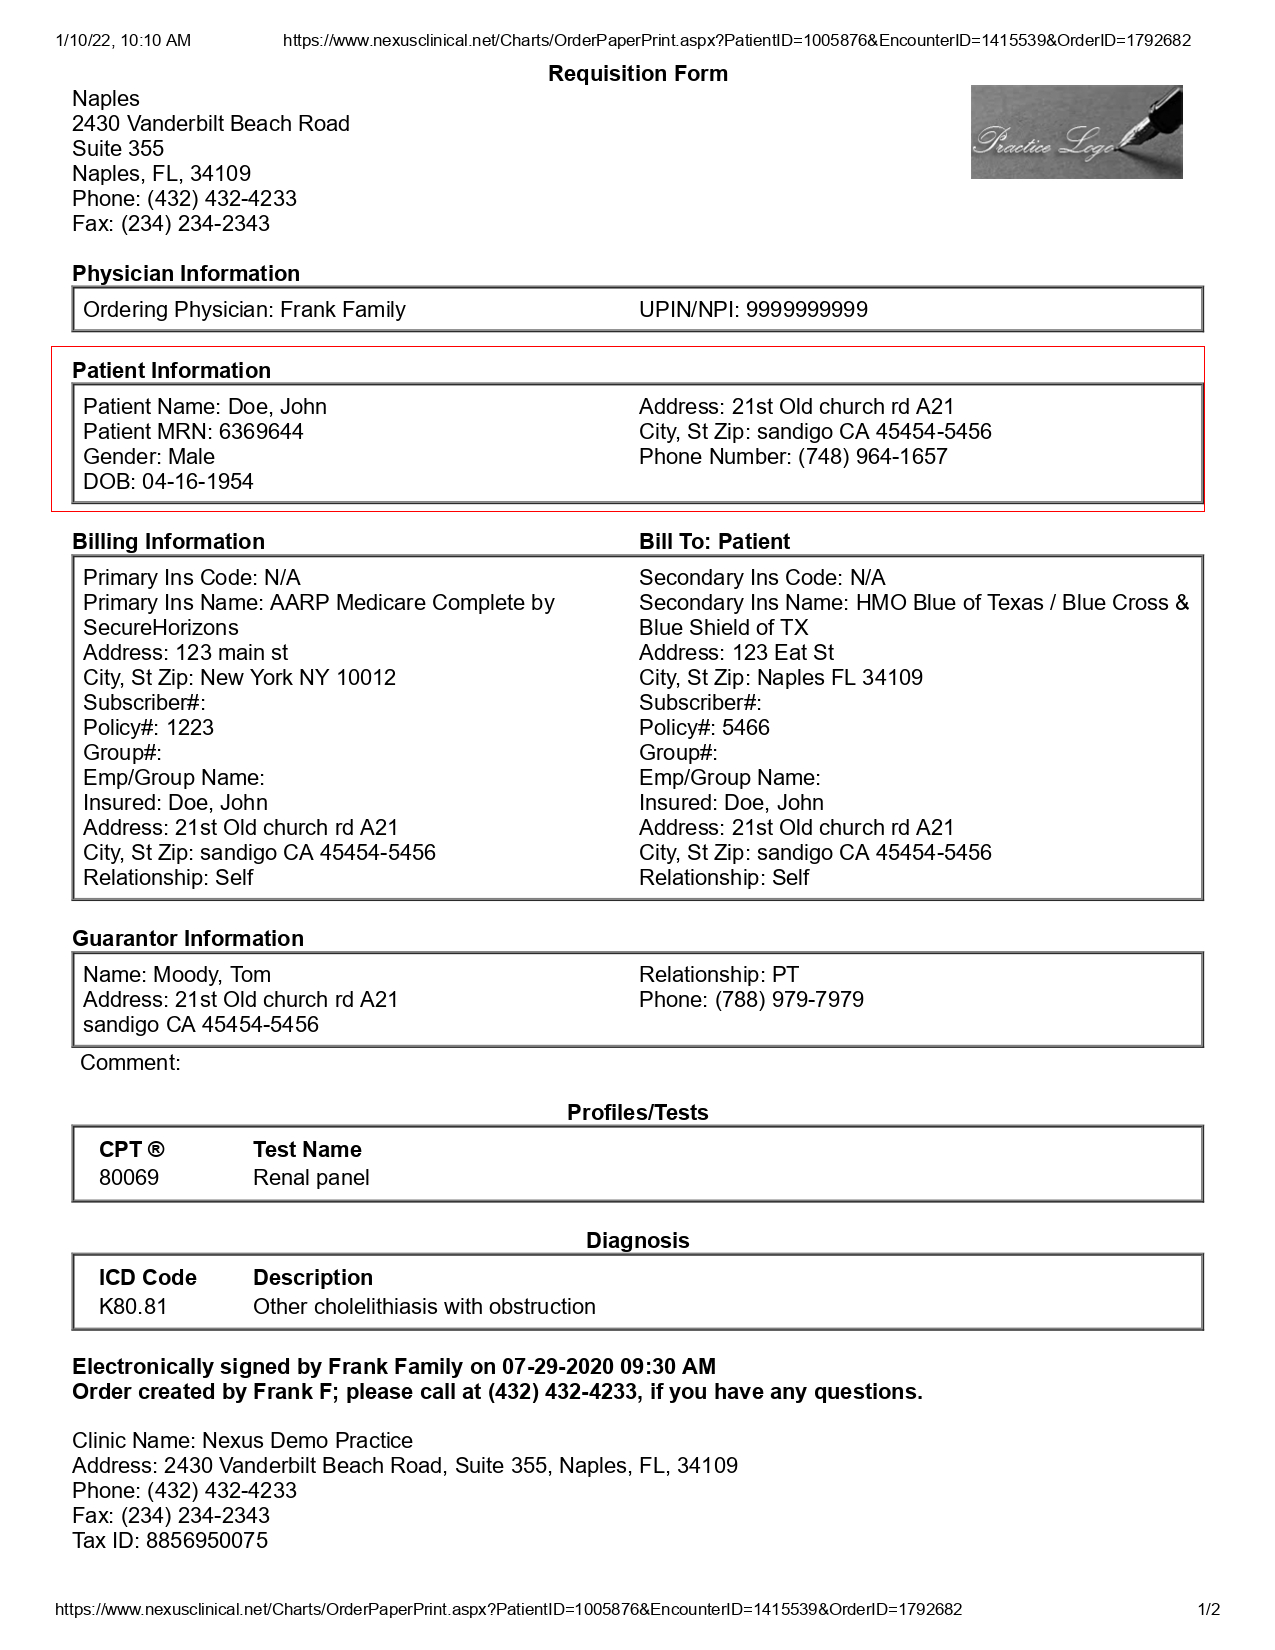

In [9]:
image.show()

In [25]:
lines = doc.pages[0].getLinesInBoundingBox( trp.BoundingBox(**{"width": 0.905, "height": 0.1,"left": 0.04, "top": 0.21}))

In [26]:
for line in lines:
    print(line.text)

Patient Information
Patient Name: Doe, John
Address: 21st Old church rd A21
Patient MRN: 6369644
City, St Zip: sandigo CA 45454-5456
Gender: Male
Phone Number: (748) 964-1657
DOB: 04-16-1954


In [53]:
dir(doc.pages[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_blocks',
 '_content',
 '_form',
 '_geometry',
 '_id',
 '_lines',
 '_parse',
 '_tables',
 '_text',
 'blocks',
 'content',
 'form',
 'geometry',
 'getLinesInBoundingBox',
 'getLinesInReadingOrder',
 'getTextInReadingOrder',
 'id',
 'lines',
 'tables',
 'text']

In [35]:
for field in doc.pages[0].form.fields:
    print(field.key, "------" ,field.value)

Address: ------ 21st Old church rd A21
Address: ------ 21st Old church rd A21
Address: ------ 123 Eat St
City, St Zip: ------ sandigo CA 45454-5456
Address: ------ 21st Old church rd A21
Phone: ------ (788) 979-7979
City, St Zip: ------ sandigo CA 45454-5456
Relationship: ------ PT
UPIN/NPI: ------ 9999999999
Address: ------ 123 main st
City, St Zip: ------ Naples FL 34109
Insured: ------ Doe, John
Policy#: ------ 5466
Patient MRN: ------ 6369644
Patient Name: ------ Doe, John
Insured: ------ Doe, John
City, St Zip: ------ sandigo CA 45454-5456
City, St Zip: ------ New York NY 10012
Clinic Name: ------ Nexus Demo Practice
Phone Number: ------ (748) 964-1657
Address: ------ 2430 Vanderbilt Beach Road, Suite 355, Naples, FL, 34109
Phone: ------ (432) 432-4233
Primary Ins Name: ------ AARP Medicare Complete by
Secondary Ins Name: ------ HMO Blue of Texas / Blue Cross &
Policy#: ------ 1223
Name: ------ Moody, Tom
Tax ID: ------ 8856950075
Primary Ins Code: ------ N/A
Phone: ------ (432) 4